In [1]:
# install some requirement libraries
!pip install split-folders
!pip install torch-summary

In [2]:
# import requirement libraries and tools
import os
import pathlib
import numpy as np
import splitfolders
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchsummary import summary

In [3]:
# dataset path
data_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
data_path = pathlib.Path(data_path)

In [4]:
# create folder for train, validation and test set
splitfolders.ratio(input=data_path, output='rice_imgs', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [15:03, 83.02 files/s] 


<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Preparing Dataset</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

In [5]:
# new dataset path
data_dir = '/kaggle/working/rice_imgs'
data_dir = pathlib.Path(data_dir)

In [6]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)

# import and load train, validation and test set
BATCH_SIZE = 32

train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
print("Tarin", train_set, "\n")
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
print("Validation", val_set, "\n")
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.ImageFolder(data_dir.joinpath("test"), transform=transform)
print("Test", test_set, "\n")
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

class_names = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")

Tarin Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/rice_imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Validation Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/rice_imgs/val
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Test Dataset ImageFolder
    Number of datapoints: 1125

In [7]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": val_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Train:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Validation:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64

Test:
Shape of X [N, C, H, W]: torch.Size([32, 3, 250, 250])
Shape of y: torch.Size([32]) torch.int64



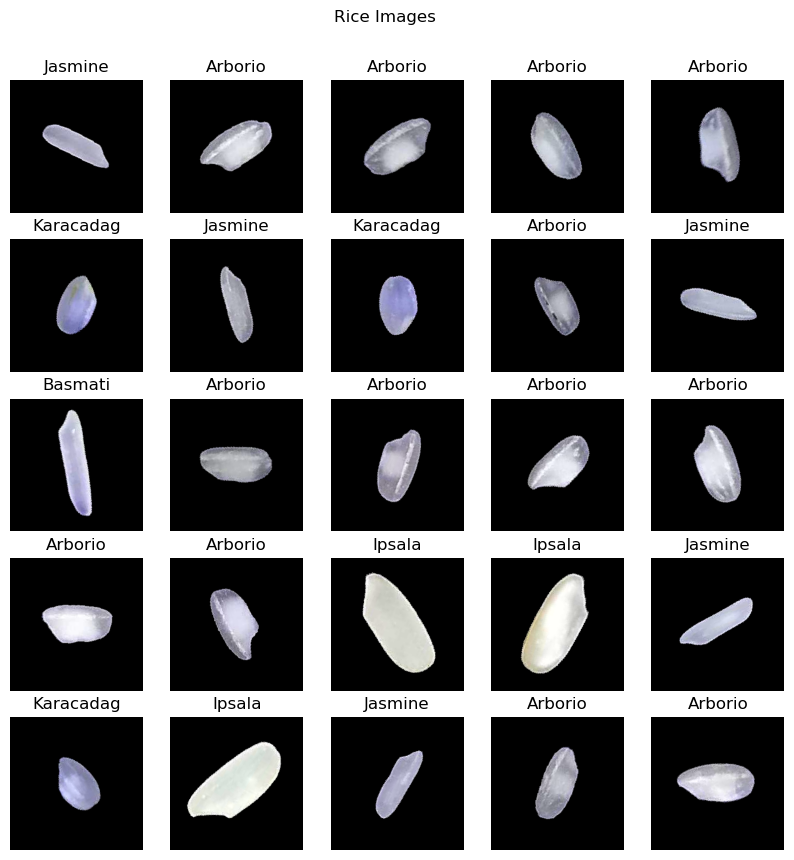

In [8]:
# visualizing the dataset for check it
labels_map = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Rice Images', y=0.95)
plt.show()

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">4. Build, Train & Test CNN Model</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

<div style="font-family:Georgia;line-height:25px"> To find and appropriate model size, it's best ot strat with raltively few layers and parameters, Then we start increasing the size of the layers or adding new layers until we see diminishing returns in validation loss.
</div>

<a id="4_1"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:100%;color:white;text-align:center;border-radius:15px 50px; padding:7px">4.1. Model 1</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

In [9]:
# Define first CNN Model: 1 conv layer | 1 pool layer | 2 full-connected layer | RelU activation
class Model1(nn.Module):
    def __init__(self, dim_output):
        super().__init__()

        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=32*124*124, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=dim_output),
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

model_1 = Model1(5)

In [10]:
# print summary of model like summary in tensorflow
summary(model_1, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 124, 124]        --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-4                       [-1, 500]                 246,016,500
|    └─ReLU: 2-5                         [-1, 500]                 --
|    └─Linear: 2-6                       [-1, 5]                   2,505
Total params: 246,019,901
Trainable params: 246,019,901
Non-trainable params: 0
Total mult-adds (M): 545.18
Input size (MB): 0.72
Forward/backward pass size (MB): 15.02
Params size (MB): 938.49
Estimated Total Size (MB): 954.23

In [11]:
# get Device for Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"Using {device} device")

Using cuda device


In [12]:
# mode model to GPU
model_1 = model_1.to(device)
model_1

Model1(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=492032, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [13]:
# define a Loss function and optimizer for model_1
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [14]:
# define function for train model
def train(model, train_loader, validation_loader, device,
          loss_fn, optimizer, num_epochs, patience=3):
    """
    Train model on train loader:
        model: created model
        train_loader: train_set that load by DataLoader
        validation_loader: validation set that load by DataLoader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
        optimizer: defined optimizer
        num_epochs (int): number of epochs
        patience (int): for early stopping
    
    """
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    epoch = 0
    best_val_loss = float('inf')
    best_model_weights = None
    early_stopping_counter = 0

    while epoch < num_epochs and early_stopping_counter < patience:
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), ncols=600, total=len(train_loader))
        for batch_idx, (inputs, labels) in pbar:
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs} ')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = evaluate(model, validation_loader, device, loss_fn)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f'train_loss: {train_loss:.4f} | '
              f'train_acc: {train_acc:.4f} | ' +
              f'val_loss: {val_loss:.4f} | ' +
              f'val_acc: {val_acc:.4f}', '\n')

        if history['val_loss'][-1] < best_val_loss:
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        best_val_loss = history['val_loss'][-1]
        epoch += 1

    return history, best_model_weights

# ---------------------------------------------------------------

def evaluate(model, data_loader, device, loss_fn):
    """
    Evaluate models and return loss and accuracy of model
        model: created model
        data_loader: test or validation loader
        device: available device for train model (cpu or cuda)
        loss_fn: defined loss function
    """

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = total_loss / len(data_loader)
    val_acc = correct / total

    return val_loss, val_acc

# -------------------------------------------------------------------

def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot train and validation accuracy
    axs[0].plot(model['history']['train_acc'], color="red", marker="o")
    axs[0].plot(model['history']['val_acc'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
    # Plot train and validation loss
    axs[1].plot(model['history']['train_loss'], color="red", marker="o")
    axs[1].plot(model['history']['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------

# define function for create two list include y_true and y_pred
def get_ture_and_pred_labels(dataloader, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
    """
    i = 0
    y_true = []
    y_pred = []
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()



In [15]:
# train model_1
history_1, best_model_weights_1 = train(model_1, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=100)

  0%|                                                                                                         …

train_loss: 0.6155 | train_acc: 0.9682 | val_loss: 0.0447 | val_acc: 0.9865 

train_loss: 0.0416 | train_acc: 0.9868 | val_loss: 0.0921 | val_acc: 0.9725 



  0%|                                                                                                         …

train_loss: 0.0396 | train_acc: 0.9873 | val_loss: 0.0309 | val_acc: 0.9897 



  0%|                                                                                                         …

train_loss: 0.0365 | train_acc: 0.9889 | val_loss: 0.0387 | val_acc: 0.9885 



  0%|                                                                                                         …

train_loss: 0.0461 | train_acc: 0.9872 | val_loss: 0.0388 | val_acc: 0.9883 



  0%|                                                                                                         …

train_loss: 0.0301 | train_acc: 0.9907 | val_loss: 0.0203 | val_acc: 0.9935 



  0%|                                                                                                         …

train_loss: 0.0309 | train_acc: 0.9914 | val_loss: 0.0261 | val_acc: 0.9923 



  0%|                                                                                                         …

train_loss: 0.0237 | train_acc: 0.9930 | val_loss: 0.0151 | val_acc: 0.9960 



  0%|                                                                                                         …

train_loss: 0.0239 | train_acc: 0.9931 | val_loss: 0.0479 | val_acc: 0.9850 



  0%|                                                                                                         …

train_loss: 0.0202 | train_acc: 0.9941 | val_loss: 0.0311 | val_acc: 0.9906 



  0%|                                                                                                         …

train_loss: 0.0256 | train_acc: 0.9939 | val_loss: 0.0183 | val_acc: 0.9950 



  0%|                                                                                                         …

train_loss: 0.0167 | train_acc: 0.9952 | val_loss: 0.0173 | val_acc: 0.9962 



  0%|                                                                                                         …

train_loss: 0.0187 | train_acc: 0.9950 | val_loss: 0.0126 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0205 | train_acc: 0.9947 | val_loss: 0.0243 | val_acc: 0.9941 



  0%|                                                                                                         …

train_loss: 0.0158 | train_acc: 0.9957 | val_loss: 0.0175 | val_acc: 0.9954 



  0%|                                                                                                         …

train_loss: 0.0139 | train_acc: 0.9962 | val_loss: 0.0196 | val_acc: 0.9938 



  0%|                                                                                                         …

train_loss: 0.0188 | train_acc: 0.9948 | val_loss: 0.0089 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0150 | train_acc: 0.9958 | val_loss: 0.0107 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0246 | train_acc: 0.9948 | val_loss: 0.0265 | val_acc: 0.9941 



  0%|                                                                                                         …

train_loss: 0.0130 | train_acc: 0.9966 | val_loss: 0.0116 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0147 | train_acc: 0.9964 | val_loss: 0.0083 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9971 | val_loss: 0.0148 | val_acc: 0.9965 



  0%|                                                                                                         …

train_loss: 0.0146 | train_acc: 0.9962 | val_loss: 0.0111 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0243 | train_acc: 0.9948 | val_loss: 0.0164 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0109 | train_acc: 0.9970 | val_loss: 0.0118 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9970 | val_loss: 0.0079 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0469 | train_acc: 0.9948 | val_loss: 0.0278 | val_acc: 0.9944 



  0%|                                                                                                         …

train_loss: 0.0164 | train_acc: 0.9955 | val_loss: 0.0252 | val_acc: 0.9946 



  0%|                                                                                                         …

train_loss: 0.0130 | train_acc: 0.9963 | val_loss: 0.0130 | val_acc: 0.9967 



  0%|                                                                                                         …

train_loss: 0.0137 | train_acc: 0.9967 | val_loss: 0.0116 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0104 | train_acc: 0.9973 | val_loss: 0.0130 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0126 | train_acc: 0.9965 | val_loss: 0.0115 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0099 | train_acc: 0.9974 | val_loss: 0.0174 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9970 | val_loss: 0.0217 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0138 | train_acc: 0.9966 | val_loss: 0.0161 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0110 | train_acc: 0.9970 | val_loss: 0.0101 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9968 | val_loss: 0.0119 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9971 | val_loss: 0.0111 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0078 | train_acc: 0.9978 | val_loss: 0.0153 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0131 | train_acc: 0.9967 | val_loss: 0.0170 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0130 | train_acc: 0.9970 | val_loss: 0.0132 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0155 | train_acc: 0.9965 | val_loss: 0.0139 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0189 | train_acc: 0.9965 | val_loss: 0.0111 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0093 | train_acc: 0.9975 | val_loss: 0.0762 | val_acc: 0.9884 



  0%|                                                                                                         …

train_loss: 0.0104 | train_acc: 0.9973 | val_loss: 0.0183 | val_acc: 0.9965 



  0%|                                                                                                         …

train_loss: 0.0115 | train_acc: 0.9972 | val_loss: 0.0145 | val_acc: 0.9973 



  0%|                                                                                                         …

train_loss: 0.0088 | train_acc: 0.9977 | val_loss: 0.0112 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0162 | train_acc: 0.9966 | val_loss: 0.0302 | val_acc: 0.9944 



  0%|                                                                                                         …

train_loss: 0.0072 | train_acc: 0.9980 | val_loss: 0.0136 | val_acc: 0.9953 



  0%|                                                                                                         …

train_loss: 0.0086 | train_acc: 0.9975 | val_loss: 0.0094 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0106 | train_acc: 0.9977 | val_loss: 0.0154 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0137 | train_acc: 0.9970 | val_loss: 0.0173 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0066 | train_acc: 0.9981 | val_loss: 0.0108 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0076 | train_acc: 0.9980 | val_loss: 0.0179 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0088 | train_acc: 0.9976 | val_loss: 0.0161 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0115 | train_acc: 0.9975 | val_loss: 0.0158 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0073 | train_acc: 0.9981 | val_loss: 0.0105 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9971 | val_loss: 0.0119 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0112 | train_acc: 0.9974 | val_loss: 0.0220 | val_acc: 0.9951 



  0%|                                                                                                         …

train_loss: 0.0087 | train_acc: 0.9976 | val_loss: 0.0158 | val_acc: 0.9961 



  0%|                                                                                                         …

train_loss: 0.0108 | train_acc: 0.9973 | val_loss: 0.0108 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0070 | train_acc: 0.9980 | val_loss: 0.0128 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0135 | train_acc: 0.9967 | val_loss: 0.0202 | val_acc: 0.9953 



  0%|                                                                                                         …

train_loss: 0.0076 | train_acc: 0.9980 | val_loss: 0.0067 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0124 | train_acc: 0.9975 | val_loss: 0.0095 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0111 | train_acc: 0.9974 | val_loss: 0.0082 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0154 | train_acc: 0.9969 | val_loss: 0.0181 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0063 | train_acc: 0.9983 | val_loss: 0.0150 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0080 | train_acc: 0.9980 | val_loss: 0.0186 | val_acc: 0.9963 



  0%|                                                                                                         …

train_loss: 0.0086 | train_acc: 0.9978 | val_loss: 0.0105 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0130 | train_acc: 0.9974 | val_loss: 0.0140 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0056 | train_acc: 0.9985 | val_loss: 0.0169 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9979 | val_loss: 0.0121 | val_acc: 0.9973 



  0%|                                                                                                         …

train_loss: 0.0100 | train_acc: 0.9977 | val_loss: 0.0232 | val_acc: 0.9961 



  0%|                                                                                                         …

train_loss: 0.0071 | train_acc: 0.9982 | val_loss: 0.0164 | val_acc: 0.9971 



  0%|                                                                                                         …

train_loss: 0.0111 | train_acc: 0.9973 | val_loss: 0.0095 | val_acc: 0.9982 



  0%|                                                                                                         …

train_loss: 0.0114 | train_acc: 0.9977 | val_loss: 0.0258 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0099 | train_acc: 0.9977 | val_loss: 0.0185 | val_acc: 0.9960 



  0%|                                                                                                         …

train_loss: 0.0247 | train_acc: 0.9971 | val_loss: 0.0267 | val_acc: 0.9958 



  0%|                                                                                                         …

train_loss: 0.0087 | train_acc: 0.9982 | val_loss: 0.0110 | val_acc: 0.9973 



  0%|                                                                                                         …

train_loss: 0.0093 | train_acc: 0.9981 | val_loss: 0.0153 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0081 | train_acc: 0.9983 | val_loss: 0.0121 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0089 | train_acc: 0.9980 | val_loss: 0.0070 | val_acc: 0.9987 



  0%|                                                                                                         …

train_loss: 0.0139 | train_acc: 0.9976 | val_loss: 0.0131 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0064 | train_acc: 0.9984 | val_loss: 0.0151 | val_acc: 0.9971 



  0%|                                                                                                         …

train_loss: 0.0097 | train_acc: 0.9980 | val_loss: 0.0080 | val_acc: 0.9983 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9976 | val_loss: 0.0069 | val_acc: 0.9986 



  0%|                                                                                                         …

train_loss: 0.0066 | train_acc: 0.9984 | val_loss: 0.0138 | val_acc: 0.9960 



  0%|                                                                                                         …

train_loss: 0.0081 | train_acc: 0.9982 | val_loss: 0.0082 | val_acc: 0.9985 



  0%|                                                                                                         …

train_loss: 0.0071 | train_acc: 0.9983 | val_loss: 0.0110 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0065 | train_acc: 0.9982 | val_loss: 0.0164 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0089 | train_acc: 0.9982 | val_loss: 0.0101 | val_acc: 0.9983 



  0%|                                                                                                         …

train_loss: 0.0090 | train_acc: 0.9981 | val_loss: 0.0092 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0069 | train_acc: 0.9983 | val_loss: 0.0711 | val_acc: 0.9904 



  0%|                                                                                                         …

train_loss: 0.0109 | train_acc: 0.9978 | val_loss: 0.0094 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0056 | train_acc: 0.9983 | val_loss: 0.0167 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0093 | train_acc: 0.9976 | val_loss: 0.0117 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0095 | train_acc: 0.9976 | val_loss: 0.0109 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0070 | train_acc: 0.9985 | val_loss: 0.0127 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0068 | train_acc: 0.9982 | val_loss: 0.0100 | val_acc: 0.9981 



In [16]:
# create dict for store result of train models
size_histories = {}

In [17]:
# store train results
size_histories['Model 1'] = {'history':history_1, 'weights':best_model_weights_1 }

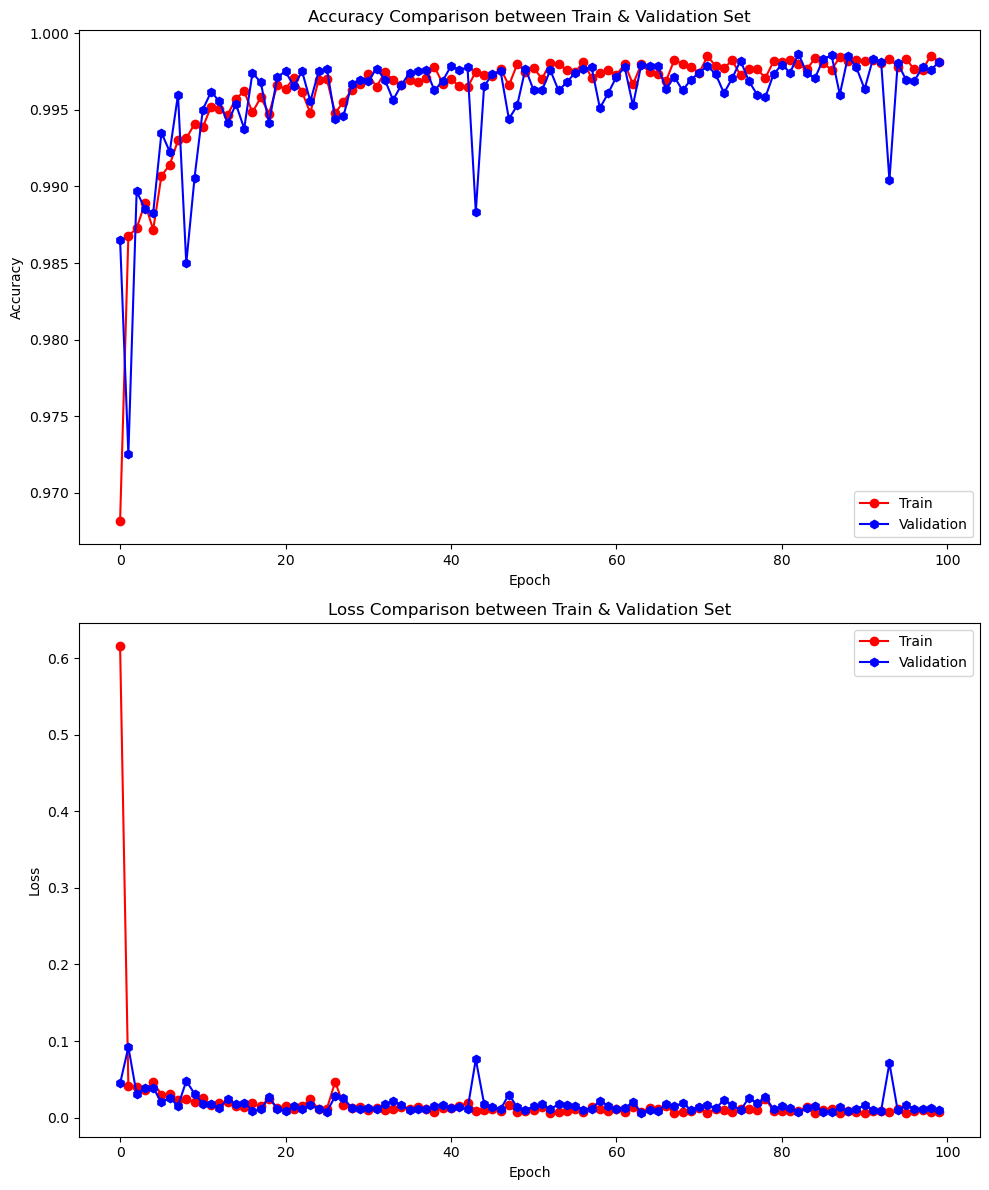

In [18]:
# plot accuracy and loss diagram per epoch for model_1  
plot_comparision_result(size_histories['Model 1'])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2250
         1.0       1.00      1.00      1.00      2250
         2.0       1.00      1.00      1.00      2250
         3.0       1.00      1.00      1.00      2250
         4.0       1.00      1.00      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250
 




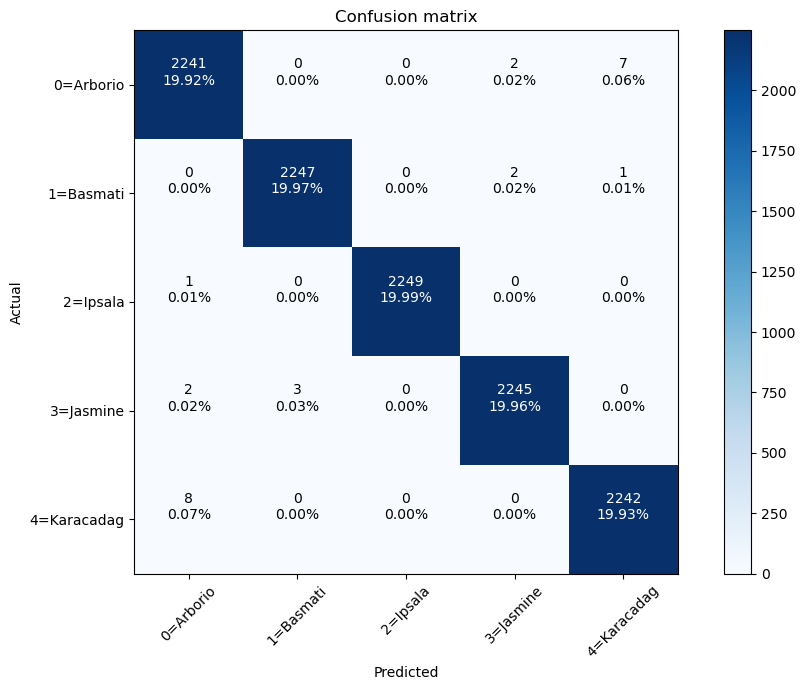

In [19]:
# check confusion matrix for error analysis
y_true, y_pred = get_ture_and_pred_labels(val_loader, model_1)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

<a id="4_2"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:100%;color:white;text-align:center;border-radius:15px 50px; padding:7px">4.2. Model 2</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

In [20]:
# Define second CNN Model: by to conv layer and 2 pool layer
class Model2(nn.Module):
    def __init__(self, dim_output):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 59 * 59, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, dim_output)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_2 = Model2(5)

In [21]:
# show summary of model_2
summary(model_2, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 246, 246]         456
├─MaxPool2d: 1-2                         [-1, 6, 123, 123]         --
├─Conv2d: 1-3                            [-1, 16, 119, 119]        2,416
├─MaxPool2d: 1-4                         [-1, 16, 59, 59]          --
├─Linear: 1-5                            [-1, 120]                 6,683,640
├─Linear: 1-6                            [-1, 84]                  10,164
├─Linear: 1-7                            [-1, 5]                   425
Total params: 6,697,101
Trainable params: 6,697,101
Non-trainable params: 0
Total mult-adds (M): 67.91
Input size (MB): 0.72
Forward/backward pass size (MB): 4.50
Params size (MB): 25.55
Estimated Total Size (MB): 30.76

In [22]:
# mode model to GPU
model_2 = model_2.to(device)
model_2

Model2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [23]:
# define a Loss function and optimizer for model_2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [24]:
# train model_2
history_2, best_model_weights_2 = train(model_2, train_loader, val_loader,
                                        device, loss_fn, optimizer, num_epochs=100, patience=5)

  0%|                                                                                                         …

train_loss: 0.1139 | train_acc: 0.9593 | val_loss: 0.0645 | val_acc: 0.9760 



  0%|                                                                                                         …

train_loss: 0.0524 | train_acc: 0.9830 | val_loss: 0.0345 | val_acc: 0.9893 



  0%|                                                                                                         …

train_loss: 0.0409 | train_acc: 0.9872 | val_loss: 0.0322 | val_acc: 0.9917 



  0%|                                                                                                         …

train_loss: 0.0349 | train_acc: 0.9895 | val_loss: 0.0172 | val_acc: 0.9944 



  0%|                                                                                                         …

train_loss: 0.0293 | train_acc: 0.9911 | val_loss: 0.0192 | val_acc: 0.9946 



  0%|                                                                                                         …

train_loss: 0.0250 | train_acc: 0.9924 | val_loss: 0.0170 | val_acc: 0.9945 



  0%|                                                                                                         …

train_loss: 0.0248 | train_acc: 0.9936 | val_loss: 0.0225 | val_acc: 0.9934 



  0%|                                                                                                         …

train_loss: 0.0251 | train_acc: 0.9923 | val_loss: 0.0878 | val_acc: 0.9822 



  0%|                                                                                                         …

train_loss: 0.0181 | train_acc: 0.9947 | val_loss: 0.0152 | val_acc: 0.9952 



  0%|                                                                                                         …

train_loss: 0.0228 | train_acc: 0.9929 | val_loss: 0.0307 | val_acc: 0.9920 



  0%|                                                                                                         …

train_loss: 0.0176 | train_acc: 0.9949 | val_loss: 0.0234 | val_acc: 0.9952 



  0%|                                                                                                         …

train_loss: 0.0160 | train_acc: 0.9950 | val_loss: 0.0102 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0179 | train_acc: 0.9952 | val_loss: 0.0447 | val_acc: 0.9878 



  0%|                                                                                                         …

train_loss: 0.0130 | train_acc: 0.9964 | val_loss: 0.0095 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0163 | train_acc: 0.9955 | val_loss: 0.0169 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0159 | train_acc: 0.9957 | val_loss: 0.0118 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0210 | train_acc: 0.9946 | val_loss: 0.0122 | val_acc: 0.9961 



  0%|                                                                                                         …

train_loss: 0.0157 | train_acc: 0.9953 | val_loss: 0.0092 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0104 | train_acc: 0.9970 | val_loss: 0.0117 | val_acc: 0.9973 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9966 | val_loss: 0.0124 | val_acc: 0.9973 



  0%|                                                                                                         …

train_loss: 0.0154 | train_acc: 0.9963 | val_loss: 0.0090 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0117 | train_acc: 0.9970 | val_loss: 0.0087 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0140 | train_acc: 0.9960 | val_loss: 0.0085 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0139 | train_acc: 0.9963 | val_loss: 0.0077 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0109 | train_acc: 0.9970 | val_loss: 0.0126 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0110 | train_acc: 0.9969 | val_loss: 0.0077 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0112 | train_acc: 0.9966 | val_loss: 0.0075 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0110 | train_acc: 0.9972 | val_loss: 0.0092 | val_acc: 0.9974 



  0%|                                                                                                         …

train_loss: 0.0127 | train_acc: 0.9966 | val_loss: 0.0108 | val_acc: 0.9969 



  0%|                                                                                                         …

train_loss: 0.0101 | train_acc: 0.9974 | val_loss: 0.0051 | val_acc: 0.9988 



  0%|                                                                                                         …

train_loss: 0.0117 | train_acc: 0.9971 | val_loss: 0.0116 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0184 | train_acc: 0.9956 | val_loss: 0.0073 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0118 | train_acc: 0.9967 | val_loss: 0.0102 | val_acc: 0.9972 



  0%|                                                                                                         …

train_loss: 0.0122 | train_acc: 0.9966 | val_loss: 0.0198 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0106 | train_acc: 0.9972 | val_loss: 0.0071 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0124 | train_acc: 0.9970 | val_loss: 0.0181 | val_acc: 0.9954 



  0%|                                                                                                         …

train_loss: 0.0166 | train_acc: 0.9960 | val_loss: 0.0184 | val_acc: 0.9956 



  0%|                                                                                                         …

train_loss: 0.0120 | train_acc: 0.9969 | val_loss: 0.0145 | val_acc: 0.9954 



  0%|                                                                                                         …

train_loss: 0.0108 | train_acc: 0.9973 | val_loss: 0.0073 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0091 | train_acc: 0.9975 | val_loss: 0.0083 | val_acc: 0.9982 



  0%|                                                                                                         …

train_loss: 0.0121 | train_acc: 0.9975 | val_loss: 0.0395 | val_acc: 0.9900 



  0%|                                                                                                         …

train_loss: 0.0110 | train_acc: 0.9972 | val_loss: 0.0140 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0127 | train_acc: 0.9973 | val_loss: 0.0084 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0081 | train_acc: 0.9979 | val_loss: 0.0078 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0173 | train_acc: 0.9970 | val_loss: 0.0098 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0076 | train_acc: 0.9978 | val_loss: 0.0094 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0066 | train_acc: 0.9981 | val_loss: 0.0090 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0106 | train_acc: 0.9974 | val_loss: 0.0100 | val_acc: 0.9977 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9974 | val_loss: 0.0100 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0075 | train_acc: 0.9978 | val_loss: 0.0130 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0218 | train_acc: 0.9953 | val_loss: 0.0059 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0088 | train_acc: 0.9975 | val_loss: 0.0079 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0055 | train_acc: 0.9985 | val_loss: 0.0078 | val_acc: 0.9983 



  0%|                                                                                                         …

train_loss: 0.0101 | train_acc: 0.9977 | val_loss: 0.0062 | val_acc: 0.9984 



  0%|                                                                                                         …

train_loss: 0.0106 | train_acc: 0.9972 | val_loss: 0.0101 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9977 | val_loss: 0.0116 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0070 | train_acc: 0.9981 | val_loss: 0.0080 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0076 | train_acc: 0.9983 | val_loss: 0.0049 | val_acc: 0.9987 



  0%|                                                                                                         …

train_loss: 0.0101 | train_acc: 0.9979 | val_loss: 0.0101 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0254 | train_acc: 0.9956 | val_loss: 0.0218 | val_acc: 0.9960 



  0%|                                                                                                         …

train_loss: 0.0096 | train_acc: 0.9979 | val_loss: 0.0067 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0075 | train_acc: 0.9982 | val_loss: 0.0162 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0117 | train_acc: 0.9976 | val_loss: 0.0061 | val_acc: 0.9985 



  0%|                                                                                                         …

train_loss: 0.0105 | train_acc: 0.9982 | val_loss: 0.0129 | val_acc: 0.9971 



  0%|                                                                                                         …

train_loss: 0.0148 | train_acc: 0.9968 | val_loss: 0.0225 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0089 | train_acc: 0.9976 | val_loss: 0.0078 | val_acc: 0.9982 



  0%|                                                                                                         …

train_loss: 0.0079 | train_acc: 0.9978 | val_loss: 0.0111 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0112 | train_acc: 0.9976 | val_loss: 0.0142 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0057 | train_acc: 0.9986 | val_loss: 0.0081 | val_acc: 0.9985 



  0%|                                                                                                         …

train_loss: 0.0143 | train_acc: 0.9966 | val_loss: 0.0066 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0086 | train_acc: 0.9978 | val_loss: 0.0097 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0175 | train_acc: 0.9959 | val_loss: 0.0209 | val_acc: 0.9961 



  0%|                                                                                                         …

train_loss: 0.0071 | train_acc: 0.9979 | val_loss: 0.0101 | val_acc: 0.9971 



  0%|                                                                                                         …

train_loss: 0.0096 | train_acc: 0.9977 | val_loss: 0.0121 | val_acc: 0.9966 



  0%|                                                                                                         …

train_loss: 0.0113 | train_acc: 0.9973 | val_loss: 0.0101 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0076 | train_acc: 0.9977 | val_loss: 0.0076 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0085 | train_acc: 0.9981 | val_loss: 0.0154 | val_acc: 0.9970 



  0%|                                                                                                         …

train_loss: 0.0098 | train_acc: 0.9978 | val_loss: 0.0065 | val_acc: 0.9988 



  0%|                                                                                                         …

train_loss: 0.0162 | train_acc: 0.9967 | val_loss: 0.0113 | val_acc: 0.9975 



  0%|                                                                                                         …

train_loss: 0.0084 | train_acc: 0.9977 | val_loss: 0.0073 | val_acc: 0.9978 



  0%|                                                                                                         …

train_loss: 0.0102 | train_acc: 0.9982 | val_loss: 0.0309 | val_acc: 0.9964 



  0%|                                                                                                         …

train_loss: 0.0115 | train_acc: 0.9978 | val_loss: 0.0065 | val_acc: 0.9985 



  0%|                                                                                                         …

train_loss: 0.0051 | train_acc: 0.9987 | val_loss: 0.0063 | val_acc: 0.9984 



  0%|                                                                                                         …

train_loss: 0.0248 | train_acc: 0.9962 | val_loss: 0.0388 | val_acc: 0.9935 



  0%|                                                                                                         …

train_loss: 0.0066 | train_acc: 0.9982 | val_loss: 0.0048 | val_acc: 0.9989 



  0%|                                                                                                         …

train_loss: 0.0053 | train_acc: 0.9986 | val_loss: 0.0101 | val_acc: 0.9980 



  0%|                                                                                                         …

train_loss: 0.0139 | train_acc: 0.9961 | val_loss: 0.0093 | val_acc: 0.9981 



  0%|                                                                                                         …

train_loss: 0.0787 | train_acc: 0.9956 | val_loss: 0.0374 | val_acc: 0.9878 



  0%|                                                                                                         …

train_loss: 0.0141 | train_acc: 0.9961 | val_loss: 0.0174 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0091 | train_acc: 0.9979 | val_loss: 0.0102 | val_acc: 0.9967 



  0%|                                                                                                         …

train_loss: 0.0091 | train_acc: 0.9974 | val_loss: 0.0205 | val_acc: 0.9955 



  0%|                                                                                                         …

train_loss: 0.0095 | train_acc: 0.9980 | val_loss: 0.0071 | val_acc: 0.9984 



  0%|                                                                                                         …

train_loss: 0.0100 | train_acc: 0.9979 | val_loss: 0.0060 | val_acc: 0.9987 



  0%|                                                                                                         …

train_loss: 0.0078 | train_acc: 0.9984 | val_loss: 0.0066 | val_acc: 0.9984 



  0%|                                                                                                         …

train_loss: 0.0190 | train_acc: 0.9964 | val_loss: 0.0076 | val_acc: 0.9979 



  0%|                                                                                                         …

train_loss: 0.0103 | train_acc: 0.9975 | val_loss: 0.0137 | val_acc: 0.9968 



  0%|                                                                                                         …

train_loss: 0.0066 | train_acc: 0.9982 | val_loss: 0.0066 | val_acc: 0.9984 



  0%|                                                                                                         …

train_loss: 0.0503 | train_acc: 0.9939 | val_loss: 0.0639 | val_acc: 0.9946 



  0%|                                                                                                         …

train_loss: 0.0143 | train_acc: 0.9968 | val_loss: 0.0100 | val_acc: 0.9976 



  0%|                                                                                                         …

train_loss: 0.0069 | train_acc: 0.9982 | val_loss: 0.0148 | val_acc: 0.9974 



In [25]:
# store train results
size_histories['Model 2'] = {'history':history_2, 'weights':best_model_weights_2 }

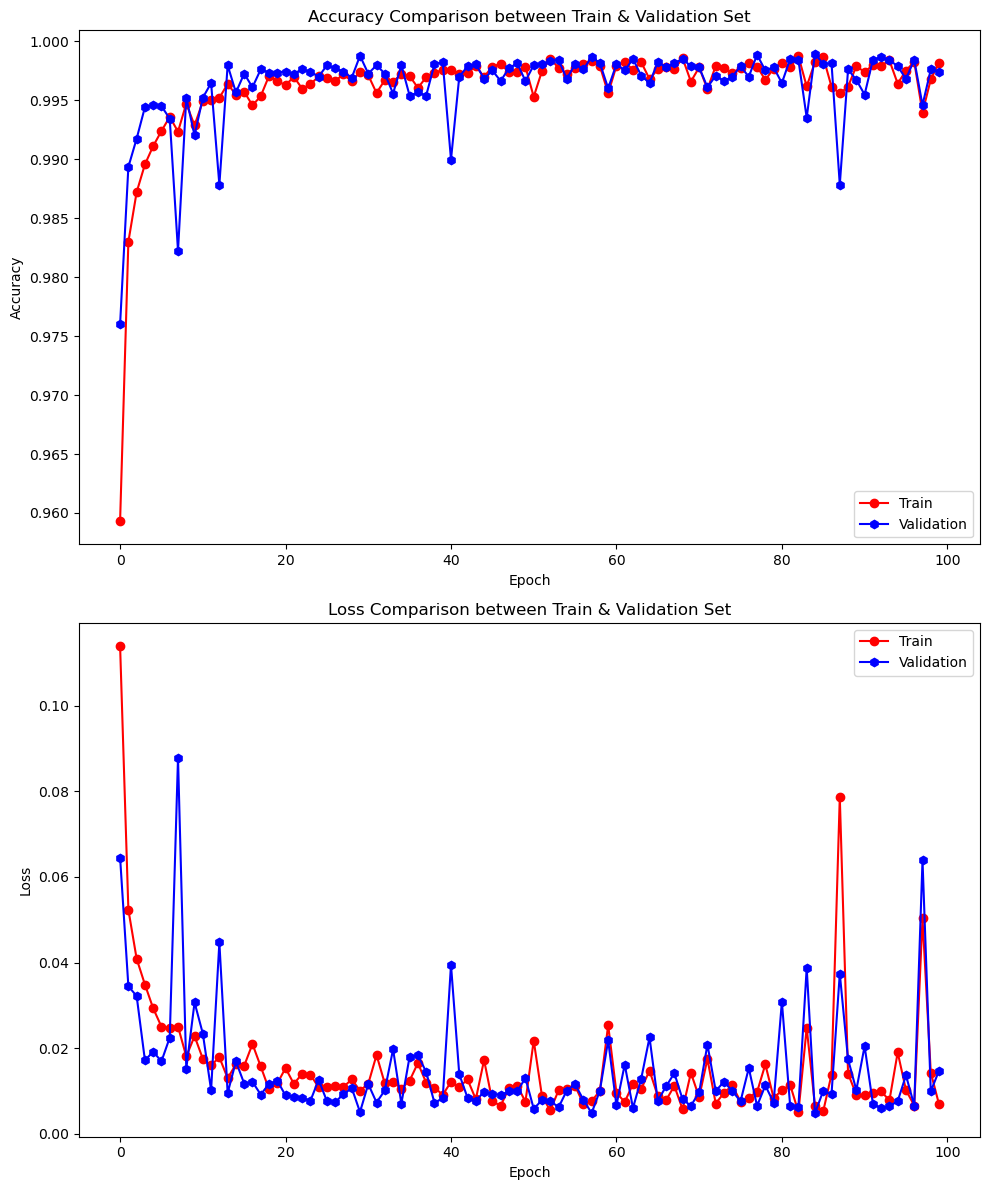

In [26]:
# plot accuracy and loss diagram per epoch for model_2  
plot_comparision_result(size_histories['Model 2'])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2250
         1.0       1.00      1.00      1.00      2250
         2.0       1.00      1.00      1.00      2250
         3.0       1.00      1.00      1.00      2250
         4.0       1.00      1.00      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250
 




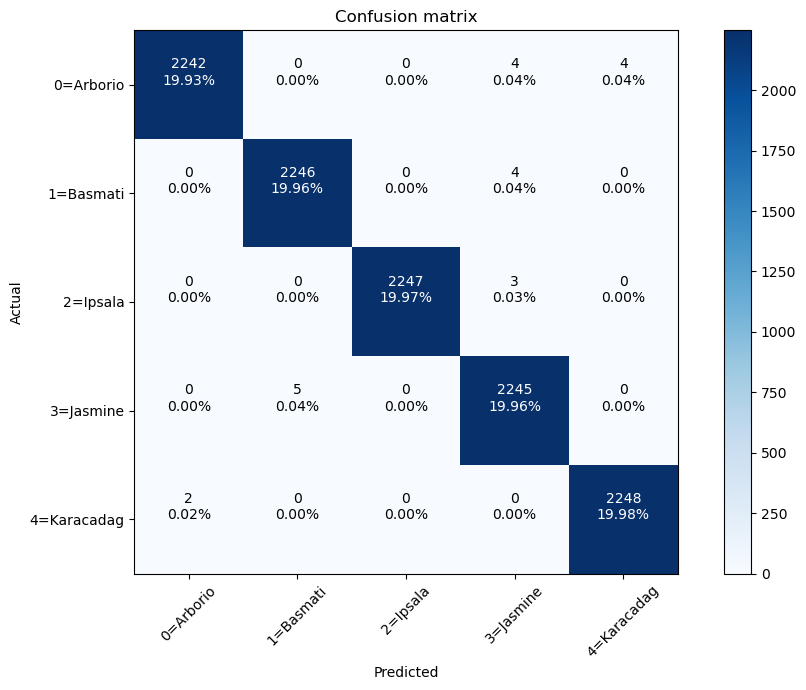

In [27]:
# check confusion matrix for error analysis
y_true, y_pred = get_ture_and_pred_labels(val_loader, model_2)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">5. Select Best Model</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

In [28]:
# choose best model as final model
final_model = model_2

In [29]:
# save final model
PATH = './cifar_net.pth'
torch.save(final_model.state_dict(), PATH)

<a id="6"></a>
# <p style="background-image: url(https://i.postimg.cc/gjzqr2mw/g4.jpg);font-family:newtimeroman;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">6. Evaluate Final Model & Visualize Results</p>

<a class="btn" href="#home">🏠 Tabel of Contents</a>

In [30]:
# evaluate model on unseen data (test set)
test_loss, test_acc = evaluate(final_model, test_loader, device, loss_fn)

print(f'Loss of the network on the {len(test_loader.dataset)} test images: {test_loss:4f}')
print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {test_acc:4f}')


Loss of the network on the 11250 test images: 0.011729
Accuracy of the network on the 11250 test images: 0.998133


In [31]:
# Store images and labels and outputs to check results of model
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model_1(images)

In [32]:
probabilities = F.softmax(outputs, dim=1)

In [33]:
def plot_image(output, true_label, img):
    """
    For plot each image
        output(Pytorch tensor): prediction for input_image
        ture_label(Pytorch tensor): true label for input_image
        img (Pytorch tensor): input_image
    """
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)

    predicted_value, predicted_label = torch.max(output, 0)
    predicted_label = predicted_label.cpu()
    true_label = true_label.cpu()

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*predicted_value,
                                class_names[true_label]),
                                color=color)

# -------------------------------------------------------------------

def plot_value_array(output, true_label):
    """
    Plot bar plot of predciton
        output(pytorch tensor): prediction array of image
        ture_label(Pytorch tensor): true label for image
    """
    
    predicted_value, predicted_label = torch.max(output, 0)
    predicted_label = predicted_label.cpu()
    true_label = true_label.cpu()
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), output.cpu().detach().numpy()*100, color="#777777")
    plt.ylim([0, 100])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# -----------------------------------------------------------------------------    
    
def plot_model_result(outputs, test_labels, test_images, num_rows=10, num_cols=3):
    """
    Plot the first X test images, their predicted labels, and the true labels.
        outputs(): all predictions for all test_image
        test_labels(): all true label for all test_image
        test_images(): all test_image
    """
    
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(outputs[i], test_labels[i], test_images[i])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(outputs[i], test_labels[i])
    plt.tight_layout()
    plt.show()

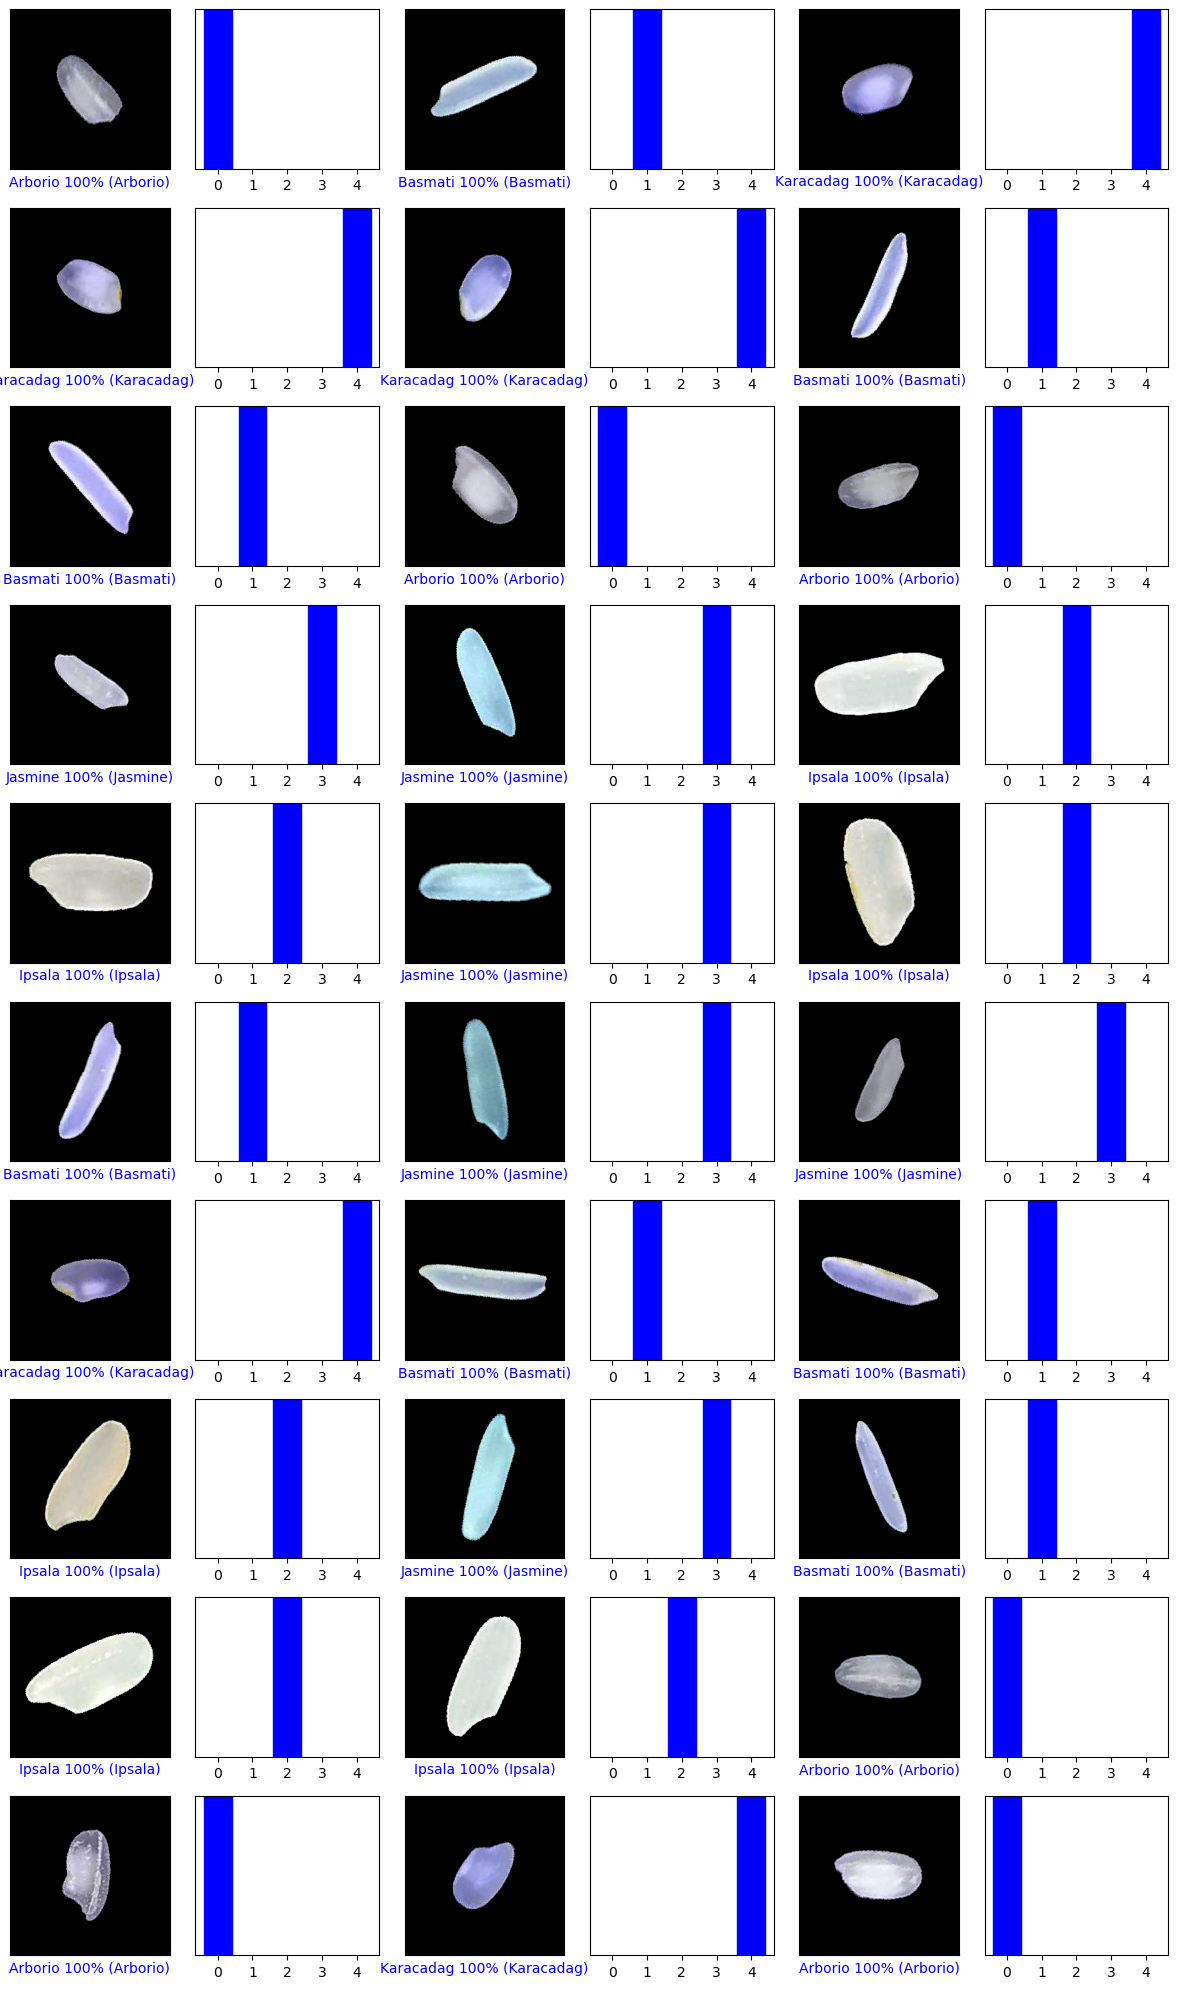

In [34]:
plot_model_result(probabilities, labels, images)